In [231]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from utils import outlier as ot

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from jcopml.tuning import random_search_params as rsp
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_residual, plot_actual_vs_prediction, plot_roc_curve

In [232]:
df = pd.read_csv("data/House_Rent_Dataset.csv", parse_dates=["Posted On"])
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


## Data Cleaning

In [233]:
df["Rental Floor"] = df["Floor"].apply(lambda x: x.split(" out of ")[0])
df["Total Number of Floor"] = df["Floor"].apply(lambda x: x.split(" out of ")[-1])
df.sample(5)

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor
2612,2022-05-05,2,8000,75,2 out of 4,Super Area,Chhattarpur,Delhi,Unfurnished,Bachelors/Family,1,Contact Owner,2,4
431,2022-05-25,1,5000,450,2 out of 2,Super Area,"Ananda Pally, Jadavpur",Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2,2
2180,2022-05-05,2,16000,1000,4 out of 5,Super Area,"Kaggadasapura, Indira nagar",Bangalore,Semi-Furnished,Bachelors/Family,2,Contact Owner,4,5
1875,2022-06-27,2,11000,800,Ground out of 4,Super Area,Battarahalli,Bangalore,Unfurnished,Bachelors/Family,2,Contact Owner,Ground,4
1887,2022-06-30,1,7500,500,1 out of 2,Carpet Area,Hosa Road Junction,Bangalore,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,2


In [234]:
df["Rental Floor"].unique()

array(['Ground', '1', '2', '4', '3', '5', '7', '8', 'Upper Basement',
       '11', 'Lower Basement', '6', '14', '43', '13', '18', '17', '9',
       '19', '60', '34', '12', '26', '25', '53', '16', '10', '39', '32',
       '47', '28', '20', '15', '65', '40', '37', '22', '21', '30', '35',
       '33', '44', '41', '46', '27', '45', '48', '50', '24', '23', '29',
       '49', '36', '76'], dtype=object)

In [235]:
df["Total Number of Floor"].unique()

array(['2', '3', '1', '4', '5', '14', '8', '6', '19', '10', '7', '13',
       '78', '18', '12', '24', '31', '21', '23', '20', '9', '22', '58',
       '16', '66', '48', '40', '44', '42', '41', '60', '32', '30', '29',
       '89', '15', '11', '28', '17', '45', '35', '75', '38', '51', '43',
       '25', '27', '26', '76', '36', '37', '55', '68', '77', '50', '59',
       '62', '39', '52', '54', '33', '46', '85', '71', '81', '34',
       'Ground'], dtype=object)

In [236]:
df["Rental Floor"] = df["Rental Floor"].replace(["Ground", "Upper Basement", "Lower Basement"], [0, -1, -2]).astype(int)
df["Total Number of Floor"] = df["Total Number of Floor"].replace("Ground", 0).astype(int)
df.drop(columns="Floor", inplace=True)
df.sample()

,Posted On,BHK,Rent,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor
2215,2022-07-07,2,12000,630,Super Area,Whitefield,Bangalore,Furnished,Bachelors/Family,2,Contact Owner,3,5


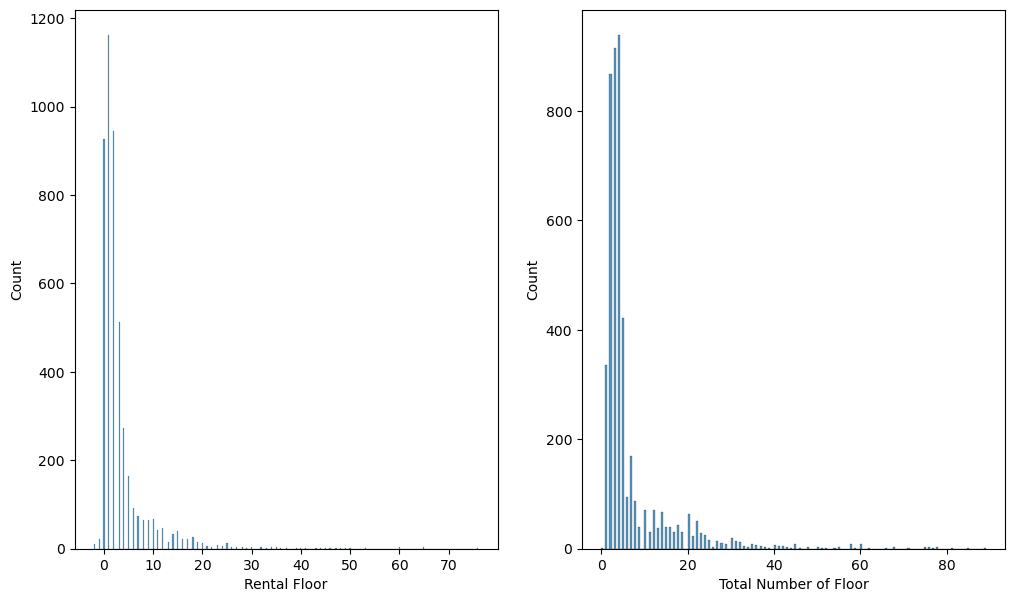

In [237]:
num_var = ["Rental Floor", "Total Number of Floor"]
fig, axes = plt.subplots(1, 2, figsize=(12,7))
for num, ax in zip(num_var, axes.flatten()):
    sns.histplot(x=num, data=df, ax=ax)

This time I will not change the outliers because it is related to data about apartment/house prices that will affect prices, especially apartments. Instead, I will add a new feature

### Category variabel

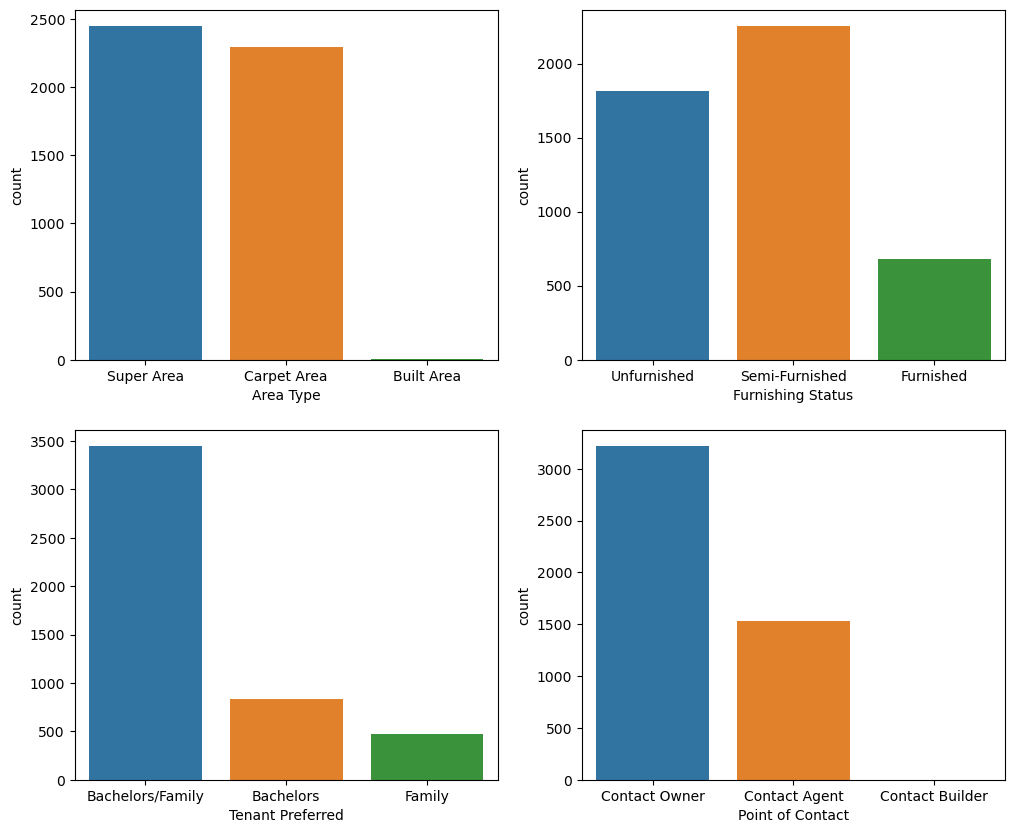

In [238]:
cat_var = ["Area Type", "Furnishing Status", "Tenant Preferred", "Point of Contact"]
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for cat, ax in zip(cat_var, axes.flatten()):
    sns.countplot(x=cat, data=df, ax=ax)

In [239]:
df.replace(to_replace=["Built Area", "Contact Builder"], 
           value=["Super Area", "Contact Owner"], inplace=True)

In [240]:
area_mean = df.query("BHK + Bathroom == 4").groupby("Area Type", as_index=False).mean()
area_mean

C:\Users\fahmi\AppData\Local\Temp\ipykernel_23180\3345422993.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Area Type,BHK,Rent,Size,Bathroom,Rental Floor,Total Number of Floor
0,Carpet Area,2.012484,34236.268414,838.001248,1.987516,4.308365,8.796504
1,Super Area,2.017787,15827.197628,933.087945,1.982213,1.777668,3.970356


`Fixed size` fitur ini dapat berhubungan dengan area, luas bangunan

In [241]:
carpet_area_size = area_mean.loc[0, "Size"]
super_area_size = area_mean.loc[1, "Size"]
area_per_multi = (super_area_size - carpet_area_size) / carpet_area_size + 1 #area prcentage multiplier
area_per_multi

1.1134684422029848

In [242]:
fixed_size = df.query("`Area Type` == 'Carpet Area'")["Size"].apply(lambda x: x * area_per_multi)
df["Fixed Size"] = np.round(fixed_size, 2)
df["Fixed Size"].fillna(df["Size"], inplace=True)
df.head()

,Posted On,BHK,Rent,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor,Fixed Size
0,2022-05-18,2,10000,1100,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2,1100.00
1,2022-05-13,2,20000,800,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,800.00
2,2022-05-16,2,17000,1000,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,1000.00
3,2022-07-04,2,10000,800,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1,2,800.00
4,2022-05-09,2,7500,850,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1,2,946.45


In [243]:
df.drop(columns=["Area Locality", "Posted On"], inplace=True)

In [244]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'xy'}]])

fig.add_trace(go.Pie(labels = df["Point of Contact"] ,name="Point of Contact", textinfo='percent+label', textposition='inside', marker=dict(line=dict(color='white', width=1))),row=1, col=1)
fig.add_trace(go.Histogram(x = df["Point of Contact"],name="Point of Contact"),row=1, col=2)

fig.update_layout(showlegend=False, title="Point of Contact", title_x=.5)

fig.show()

In [245]:
fig = go.Figure()
fig.add_trace(go.Histogram(x = df["City"], name="City", texttemplate="%{y}")).update_xaxes(categoryorder='total descending')
fig.update_layout(title="Total Number of Rental Houses in Cities", title_x=.5)
fig.show()

`Square Feet Rent` is a standardized measure used to calculate the rental cost or price of a property per unit area in square feet. This concept is commonly used in the real estate industry to simplify rental cost comparisons between properties of different sizes.

Square Feet Rent = Total Rental Cost / Total Area (in square feet)

In [246]:
square_feet_rent = df["Rent"]/df["Fixed Size"]
df["Square Feet Rent"] = np.round(square_feet_rent, 2)
df.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor,Fixed Size,Square Feet Rent
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2,1100.00,9.09
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,800.00,25.00
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,1000.00,17.00
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1,2,800.00,12.50
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1,2,946.45,7.92


#### Outlier


In [247]:
fig = px.box(df, x="Square Feet Rent", color="City")
fig.show()

In [253]:
index = ot.outlier_detect_MAD(data=df, col="Square Feet Rent", threshold=3.5)

Num of outlier detected: 827
Proportion of outlier detected 0.17425200168563001


In [254]:
df.loc[index, "Square Feet Rent"].sort_values()

1368      57.94
756       58.03
968       58.10
1117      58.11
1213      58.11
         ...   
3922     826.15
2656     853.20
4004    1000.00
1837    1257.33
4653    1347.71
Name: Square Feet Rent, Length: 827, dtype: float64

Instead of replacing the outliers with the mean/median, I should just delete them because it relates to the rental price with square feet. 

In [255]:
df = df.drop(df.query("`Square Feet Rent` > 57.94").index)

In [256]:
df.drop(columns = ["Size", "Area Type"], inplace = True)

## Correlation Matrix


C:\Users\fahmi\AppData\Local\Temp\ipykernel_23180\4095736044.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



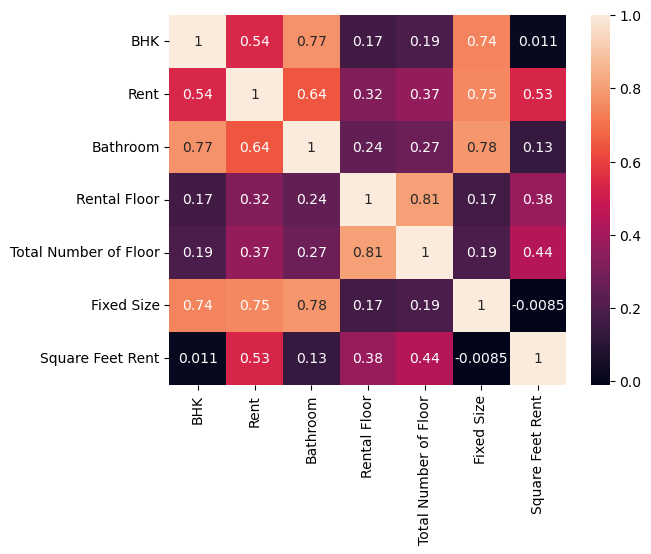

In [257]:
sns.heatmap(df.corr(), annot=True);

## Build Model

In [258]:
X = df.drop(columns='Rent')
y = df['Rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=101)
X_train.shape, X_test.shape

((2940, 10), (980, 10))

In [259]:
X_train.head()

,BHK,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor,Fixed Size,Square Feet Rent
2573,3,Delhi,Semi-Furnished,Bachelors,3,Contact Agent,1,1,1892.90,27.47
443,2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,2,556.73,10.78
1107,1,Mumbai,Semi-Furnished,Bachelors/Family,1,Contact Agent,0,7,367.44,46.27
1919,1,Bangalore,Unfurnished,Bachelors/Family,1,Contact Owner,3,3,334.04,20.96
332,1,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1,1,400.00,16.25


#### XGBRegressor

In [274]:
cat_pipe = Pipeline([("encode", OneHotEncoder(handle_unknown="ignore"))])
num_pipe = Pipeline([("scaler", StandardScaler())])

preprocessor = ColumnTransformer([
    ("numeric", num_pipe, [0,4,6,7,8,9]),
    ("categoric", cat_pipe, [1,2,3,5])
])

pipeline_xgbr = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor())
])

pipeline_xgbr.fit(X_train,y_train)
y_pred = pipeline_xgbr.predict(X_test)
print(f"Score    : {r2_score(y_test, y_pred)}")
print(f"mae      : {mean_absolute_error(y_test, y_pred)}")
print(f"root mse : {np.sqrt(mean_squared_error(y_test, y_pred))}")

Score    : 0.9845213776546449
mae      : 700.4313242386798
root mse : 2698.0959522790554


#### LGBMRegressor

In [275]:
cat_pipe = Pipeline([("encode", OneHotEncoder(handle_unknown="ignore"))])
num_pipe = Pipeline([("scaler", StandardScaler())])

preprocessor = ColumnTransformer([
    ("numeric", num_pipe, [0,4,6,7,8,9]),
    ("categoric", cat_pipe, [1,2,3,5])
])

pipeline_lgbm = Pipeline([
    ('prep', preprocessor),
    ('algo', LGBMRegressor())
])

pipeline_lgbm.fit(X_train,y_train)
y_pred = pipeline_lgbm.predict(X_test)
print(f"Score    : {r2_score(y_test, y_pred)}")
print(f"mae      : {mean_absolute_error(y_test, y_pred)}")
print(f"root mse : {np.sqrt(mean_squared_error(y_test, y_pred))}")

Score    : 0.9862029550152648
mae      : 662.0601750381039
root mse : 2547.3245339839686


## Tuning Model
I think the two models are good enough so this time I didn't tune the model.

In [264]:
# from jcopml.tuning.space import Integer, Real

In [272]:
# params = {'algo__max_depth': Integer(low=1, high=10),
#  'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
#  'algo__n_estimators': Integer(low=100, high=200),
#  'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
#  'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
#  'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
#  'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [271]:
# cat_pipe = Pipeline([("encode", OneHotEncoder(handle_unknown="ignore"))])
# num_pipe = Pipeline([("scaler", StandardScaler())])

# preprocessor = ColumnTransformer([
#     ("numeric", num_pipe, [0,4,6,7,8,9]),
#     ("categoric", cat_pipe, [1,2,3,5])
# ])

# pipeline = Pipeline([
#     ('prep', preprocessor),
#     ('algo', XGBRegressor())
# ])
    
# model = RandomizedSearchCV(pipeline, params, cv=3, n_iter=50, n_jobs=1, verbose=-1, random_state=101)
# model.fit(X_train,y_train)

# y_pred = model.predict(X_test)
# print(f"Score    : {r2_score(y_test, y_pred)}")
# print(f"mae      : {mean_absolute_error(y_test, y_pred)}")
# print(f"root mse : {np.sqrt(mean_squared_error(y_test, y_pred))}")

In [276]:
df.Rent.mean()

20692.820153061224

As we can see the RMSE value of 2547 indicates that the average prediction error is about 2547 units in rental price units. the average rental price is 20700. Thus, the difference between the RMSE (2547) and the average rental price (20700) indicates that the prediction error is relatively small compared to the range of values in the data as well as the MAE which is relatively small.

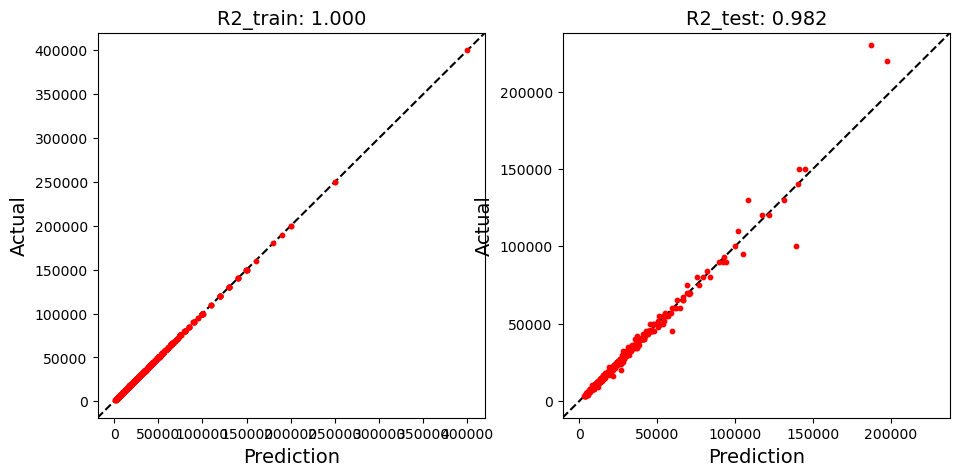

In [277]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

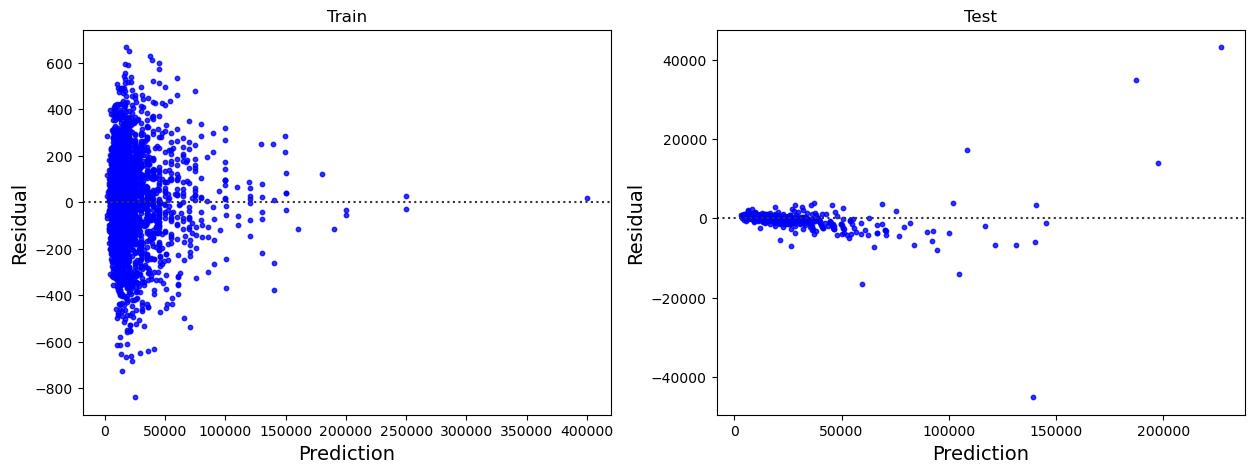

In [278]:
plot_residual(X_train, y_train, X_test, y_test, model, lowess=False)

## New Prediction

In [279]:
X_train.head(2)

,BHK,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rental Floor,Total Number of Floor,Fixed Size,Square Feet Rent
2573,3,Delhi,Semi-Furnished,Bachelors,3,Contact Agent,1,1,1892.90,27.47
443,2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,2,556.73,10.78


In [280]:
y_train.head(2)

2573    52000
443      6000
Name: Rent, dtype: int64

In [281]:
columns = X_train.columns
data = [[2, "Hyderabad", "Unfurnished", "Bachelors/Family", 2, "Contact Owner", 4, 12, 1000.0, 12.25]]
data = pd.DataFrame(data=data, columns=columns)

pred = pipeline_lgbm.predict(data)
pred

array([12180.53826797])

## Save Model

In [282]:
import pickle


with open("lgbm_model.pkl", "wb") as f:
    pickle.dump(pipeline_lgbm, f)